**# Ejemplo de Árbol de decisión**

In [428]:
######################
# adquirir datos
######################

import pandas as pd
datos = pd.read_csv("data/diabetes.csv") # dataframe

# Voy a categorizar en funcion de los casos sin diabetes (casos negativos)
casos_negativos = datos.sort_values(by='Outcome')
cantidad_casos_negativos = casos_negativos['Outcome'].value_counts(sort=False,ascending=True)[0]
casos_negativos = casos_negativos[:cantidad_casos_negativos]
# print(casos_negativos)

In [429]:
import numpy as np
# Indagacion de los datos
# Analizo los datos en busca de ceros y faltantes
caracteristicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','DiabetesPedigreeFunction']
cuenta = 0
for caract in caracteristicas:
    descriptor = datos[caract].describe()
    cuenta_de_valores = datos[caract].value_counts()
    cantidad_ceros = cuenta_de_valores[0] if 0 in cuenta_de_valores else 0
    cuenta += cantidad_ceros
    print(f'cantidad de ceros en {caract}: {cantidad_ceros}')
print(f'cuenta:{cuenta}')



cantidad de ceros en Glucose: 5
cantidad de ceros en BloodPressure: 35
cantidad de ceros en SkinThickness: 227
cantidad de ceros en Insulin: 374
cantidad de ceros en BMI: 11
cantidad de ceros en DiabetesPedigreeFunction: 0
cuenta:652


Dado que existe una cantidad significativa de ceros, y considerando que 
representan que no se midió, los paso a NaN para que no sean considerados 
en los promedios y algunos calculos

In [430]:
# Asumo que los valores nulos de `caracteristicas` no fueron medidos y los convierto a NaN
# print(datos['Glucose'].describe())
for caract in caracteristicas:
    descriptor = casos_negativos[caract].describe()
    datos[caract] = datos[caract].replace([0, 0.0], np.NaN)
    casos_negativos[caract] = casos_negativos[caract].replace([0, 0.0, '0'], np.NaN)

# print(datos['Glucose'].describe())

In [431]:

# Se prueba sacando todas las filas que contengan algun NaN
datos = datos.dropna().reset_index()
datos_segun_cuantiles = datos.copy()
print(datos_segun_cuantiles)

     index  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0        3            1     89.0           66.0           23.0     94.0  28.1   
1        4            0    137.0           40.0           35.0    168.0  43.1   
2        6            3     78.0           50.0           32.0     88.0  31.0   
3        8            2    197.0           70.0           45.0    543.0  30.5   
4       13            1    189.0           60.0           23.0    846.0  30.1   
..     ...          ...      ...            ...            ...      ...   ...   
387    753            0    181.0           88.0           44.0    510.0  43.3   
388    755            1    128.0           88.0           39.0    110.0  36.5   
389    760            2     88.0           58.0           26.0     16.0  28.4   
390    763           10    101.0           76.0           48.0    180.0  32.9   
391    765            5    121.0           72.0           23.0    112.0  26.2   

     DiabetesPedigreeFuncti

In [432]:
# Pre-procesamiento de datos. Categorizacion de 'Age'
def mapearEdades(edad):
    if (edad >= 0 and edad <= 11): return 0 # 'niño'
    elif (edad >= 12 and edad <= 18): return 1 # 'adolescente'
    elif (edad >= 19 and edad <= 25): return 2 # 'joven'
    elif (edad >= 26 and edad <= 59): return 3 # 'adulto'
    elif (edad >= 60 and edad <= 70): return 4 # 'mayor'
    
datos['Age'] = datos['Age'].apply(mapearEdades)

In [433]:
# En este punto hago una copia de datos para preprocesarlo con otro método
datos_segun_cuantiles = datos.copy()

In [434]:
# Pre-procesamiento de datos. Categorizacion de 'Glucose'
# IMPORTANTE: Categorizo en función de los casos SIN diabetes
descriptor = casos_negativos['Glucose'].describe()

intervalos_glucosa_segun_promedio = [
    descriptor['min'], 
    descriptor['mean'] - descriptor['std'], 
    descriptor['mean'] + descriptor['std'], 
    descriptor['max']
    ]
etiquetas_glucosa = [0, 1, 2]

datos['Glucose'] = pd.cut(datos['Glucose'], bins=intervalos_glucosa_segun_promedio, labels=etiquetas_glucosa)
# print(datos)

In [435]:
# Categorizo el resto de las caracteristicas segun el bloque anterior
caracteristicas_restantes = ['BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']

for caract in caracteristicas_restantes:
    descriptor = casos_negativos[caract].describe()
    # print(descriptor)
    intervalos = [
        descriptor['min'], 
        descriptor['mean'] - descriptor['std'], 
        descriptor['mean'] + descriptor['std'], 
        descriptor['max']
        ]
    etiquetas = [0, 1, 2]

    datos[caract] = pd.cut(datos[caract], bins=intervalos, labels=etiquetas)
    # print(datos)


In [436]:
# Categorizo en funcion de cuartiles
caracteristicas_a_categorizar = caracteristicas.copy()
# caracteristicas_a_categorizar.insert(0, 'Age')

CANTIDAD_CATEGORIAS = 10
for caract in caracteristicas_a_categorizar:
    print(caract)
    datos_segun_cuantiles[caract], intervalos_q = pd.qcut(
        x=datos_segun_cuantiles[caract], 
        q=CANTIDAD_CATEGORIAS, 
        labels=[cat for cat in range(CANTIDAD_CATEGORIAS)], 
        retbins=True,
        duplicates='drop'
    )
    # print(pd.value_counts(datos_segun_cuantiles[caract]))

Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction


In [437]:
# IMPORTANTE: Falta normalizar

### Splitting de datos

In [438]:
# Splitting de datos

from sklearn.model_selection import train_test_split

caracteristicas_entrada = [
    # 'Pregnancies', 
    'Glucose',
    'BloodPressure', 
    'SkinThickness', 
    'BMI', 
    'DiabetesPedigreeFunction', 
    'Insulin',
    'Age']
caracteristicas_objetivo = 'Outcome'

X_train, X_test, y_train, y_test = train_test_split(
    datos[caracteristicas_entrada],
    datos[caracteristicas_objetivo],
    test_size = 0.3
    )

X_segun_cuantiles_train, X_segun_cuantiles_test, y_segun_cuantiles_train, y_segun_cuantiles_test = train_test_split(
    datos_segun_cuantiles[caracteristicas_entrada],
    datos_segun_cuantiles[caracteristicas_objetivo],
    test_size = 0.3
    )

In [439]:
from unittest import mock
from sklearn import tree
import sklearn
PROFUNDIDAD_ARBOL = 4

arbol_segun_media = tree.DecisionTreeClassifier(criterion='entropy', max_depth=PROFUNDIDAD_ARBOL)
arbol_segun_cuantiles = tree.DecisionTreeClassifier(criterion='entropy', max_depth=PROFUNDIDAD_ARBOL)
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    arbol_segun_media.fit(X=X_train, y=y_train)
    arbol_segun_cuantiles.fit(X=X_segun_cuantiles_train, y=y_segun_cuantiles_train)
    

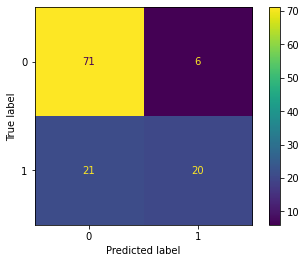

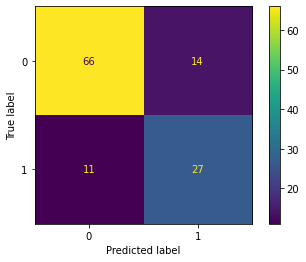

In [440]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Analizar modelo
predicciones_segun_media = []
predicciones_segun_cuantiles = []
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    predicciones_segun_media = arbol_segun_media.predict(X=X_test)
    predicciones_segun_cuantiles = arbol_segun_cuantiles.predict(X=X_segun_cuantiles_test)

matriz_confusion_segun_media = confusion_matrix(y_true=y_test, y_pred=predicciones_segun_media)
matriz_confusion_segun_cuantiles = confusion_matrix(y_true=y_segun_cuantiles_test, y_pred=predicciones_segun_cuantiles)

widget_matriz_confusion_segun_media = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion_segun_media,
    display_labels=arbol_segun_media.classes_
    )
widget_matriz_confusion_segun_cuantiles = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion_segun_cuantiles,
    display_labels=arbol_segun_cuantiles.classes_
    )
widget_matriz_confusion_segun_media.plot()
widget_matriz_confusion_segun_cuantiles.plot()
plt.show()

[Text(0.5340909090909091, 0.9, 'X[0] <= 1.5\nentropy = 0.91\nsamples = 274\nvalue = [185, 89]'),
 Text(0.29545454545454547, 0.7, 'X[6] <= 2.5\nentropy = 0.709\nsamples = 191\nvalue = [154, 37]'),
 Text(0.18181818181818182, 0.5, 'X[2] <= 1.5\nentropy = 0.429\nsamples = 91\nvalue = [83, 8]'),
 Text(0.09090909090909091, 0.3, 'X[1] <= 1.5\nentropy = 0.334\nsamples = 81\nvalue = [76, 5]'),
 Text(0.045454545454545456, 0.1, 'entropy = 0.306\nsamples = 73\nvalue = [69, 4]'),
 Text(0.13636363636363635, 0.1, 'entropy = 0.544\nsamples = 8\nvalue = [7, 1]'),
 Text(0.2727272727272727, 0.3, 'X[5] <= 1.5\nentropy = 0.881\nsamples = 10\nvalue = [7, 3]'),
 Text(0.22727272727272727, 0.1, 'entropy = 0.764\nsamples = 9\nvalue = [7, 2]'),
 Text(0.3181818181818182, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.4090909090909091, 0.5, 'X[2] <= 0.5\nentropy = 0.869\nsamples = 100\nvalue = [71, 29]'),
 Text(0.36363636363636365, 0.3, 'entropy = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.45454545

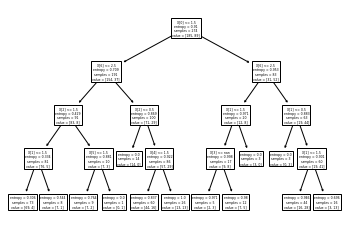

In [441]:
# print(X_train)
tree.plot_tree(arbol_segun_media)

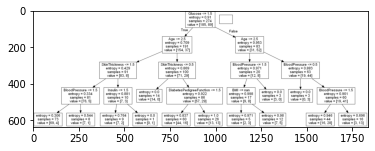

In [442]:
from matplotlib import image as pltimg
from matplotlib import pyplot as plt
import pydotplus

data = tree.export_graphviz(arbol_segun_media, feature_names=caracteristicas_entrada,out_file=None)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png("mi_arbol.png")

img = pltimg.imread("mi_arbol.png")
imgplot = plt.imshow(img)
plt.show()